# Visión por Computadora II - TP Integrador

**Dataset**: [fruits-360](https://www.kaggle.com/datasets/moltean/fruits)

In [38]:
# importamos librerias
!pip install torchmetrics --quiet

import os
import shutil
import gdown
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
from PIL import Image
from collections import Counter

import torch
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torchvision.models.vgg import VGG19_Weights
from torchvision.models import mobilenet_v2

---
## 1) Dataset

In [2]:
dataset_zip = 'fruits-360_100x100.zip'
%store dataset_zip

# Descargar el dataset
if os.access(dataset_zip, os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL'
    gdown.download(url, dataset_zip)
else:
    print("El dataset ya se encuentra descargado")

Stored 'dataset_zip' (str)
El dataset ya se encuentra descargado


In [3]:
!unzip -n -q "$dataset_zip"

replace LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


---
### 1.1) Análisis exploratorio

- El dataset Fruit-360 es una colección diseñada específicamente para tareas de clasificación de frutas. Contiene un total de 81 clases, cada una representando una categoría diferente de frutas. El conjunto de datos está organizado en:
   - Conjunto de entrenamiento: 70491 imágenes.
   - Conjunto de prueba: 23619 imágenes.
   - En total, el dataset incluye 94110 imágenes.

- Para capturar las imágenes, se utilizó un motor de baja velocidad (3 rpm) que giraba las frutas, grabando un corto video de 20 segundos. Debido a las variaciones en las condiciones de iluminación durante las filmaciones, los fondos originales no eran uniformes. Por esta razón, se estandarizó el fondo de todas las imágenes, convirtiéndolo en color blanco.

- Cada imagen tiene un tamaño de 100x100 píxeles con fondo blanco. Esta resolución y uniformidad son esenciales para la clasificación de imágenes, ya que muchas frutas comparten colores y formas similares, aunque difieren en tamaño. A su vez, algunas frutas tienen el mismo tamaño, color y forma, pero pertenecen a diferentes variedades dentro de una misma categoría (por ejemplo, variantes de manzanas, mangos o tomates). Para abordar esta diversidad, las distintas variantes de una misma fruta se clasificaron como clases separadas.

- A diferencia de otros datasets generales de clasificación de imágenes, el Fruit-360 se enfoca exclusivamente en frutas. Esto implica un desafío adicional debido a las grandes similitudes intra-clase, ya que frutas de la misma categoría comparten características visuales muy similares. Por lo tanto, este dataset representa un excelente punto de partida para explorar las capacidades de modelos de clasificación de imágenes y analizar su rendimiento frente a clases con características sutilmente diferenciadas.

In [4]:
# imprimir cantidad de imagenes de train y test
train_folder = 'Training/'
test_folder = 'Test/'

train_images = sum([len(files) for r, d, files in os.walk(train_folder)])
test_images = sum([len(files) for r, d, files in os.walk(test_folder)])
total_images = train_images + test_images

print(f"Cantidad de imagenes en train: {train_images}")
print(f"Cantidad de imagenes en test: {test_images}")
print(f"Total de imagenes: {total_images}")

Cantidad de imagenes en train: 70491
Cantidad de imagenes en test: 23619
Total de imagenes: 94110


In [6]:
# exploracion de las clases del dataset
classes = os.listdir(train_folder)
print(f"Se encontraron {len(classes)} clases de frutas")
print(f"Primeras 10 clases:")
print(classes[:10])

# todo: mergear las clases que tienen varias tomas de la misma fruta/verdura

Se encontraron 141 clases de frutas
Primeras 10 clases:
['Pineapple Mini 1', 'Pear Red 1', 'Potato Red 1', 'Apple Braeburn 1', 'Grape Pink 1', 'Avocado 1', 'Apple Red 3', 'Maracuja 1', 'Potato Red Washed 1', 'Tangelo 1']


In [7]:
# cantidad de imágenes por clase
class_counts = {cls: len(os.listdir(os.path.join(train_folder, cls))) for cls in classes}
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(f"Cantidad de imágenes por clase:")
print(sorted_class_counts)

Cantidad de imágenes por clase:
{'Grape Blue 1': 984, 'Plum 3': 900, 'Strawberry Wedge 1': 738, 'Tomato 1': 738, 'Melon Piel de Sapo 1': 738, 'Tomato 3': 738, 'Cherry 2': 738, 'Cherry Rainier 1': 738, 'Peach 2': 738, 'Walnut 1': 735, 'Pear Stone 1': 711, 'Pear Forelle 1': 702, 'Cauliflower 1': 702, 'Fig 1': 702, 'Pepper Orange 1': 702, 'Apple hit 1': 702, 'Pear 2': 696, 'Tomato Heart 1': 684, 'Tomato 2': 672, 'Apple Red Yellow 2': 672, 'Pear Red 1': 666, 'Pepper Yellow 1': 666, 'Pepper Red 1': 666, 'Nut Forest 1': 654, 'Nut Pecan 1': 534, 'Pineapple Mini 1': 493, 'Apple Braeburn 1': 492, 'Grape Pink 1': 492, 'Peach 1': 492, 'Physalis 1': 492, 'Lemon 1': 492, 'Cherry 1': 492, 'Apple Red 2': 492, 'Cantaloupe 1': 492, 'Physalis with Husk 1': 492, 'Redcurrant 1': 492, 'Apple Granny Smith 1': 492, 'Rambutan 1': 492, 'Grapefruit White 1': 492, 'Cherry Wax Red 1': 492, 'Cherry Wax Black 1': 492, 'Tomato Cherry Red 1': 492, 'Mulberry 1': 492, 'Cherry Wax Yellow 1': 492, 'Papaya 1': 492, 'Grape

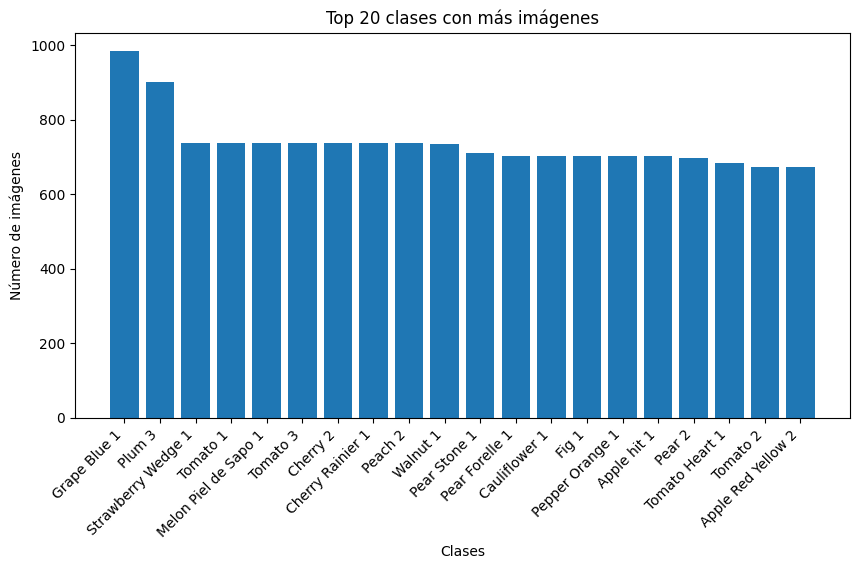

In [8]:
# visualizamos las clases con más imágenes
top_classes = dict(Counter(class_counts).most_common(20))
plt.figure(figsize=(10, 5))
plt.bar(top_classes.keys(), top_classes.values())
plt.title("Top 20 clases con más imágenes")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45, ha="right")
plt.show()

In [9]:
# tamaño de las imágenes
image_shapes = []
for cls in classes:
    folder = os.path.join(train_folder, cls)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        image_shapes.append(img.size)

widths, heights = zip(*image_shapes)
print(f"Tamaño promedio de las imágenes: {np.mean(widths):.2f}x{np.mean(heights):.2f}")
print(f"Tamaño mínimo: {min(widths)}x{min(heights)}, máximo: {max(widths)}x{max(heights)}")

Tamaño promedio de las imágenes: 100.00x100.00
Tamaño mínimo: 100x100, máximo: 100x100


---
### 1.2) Visualización de los datos

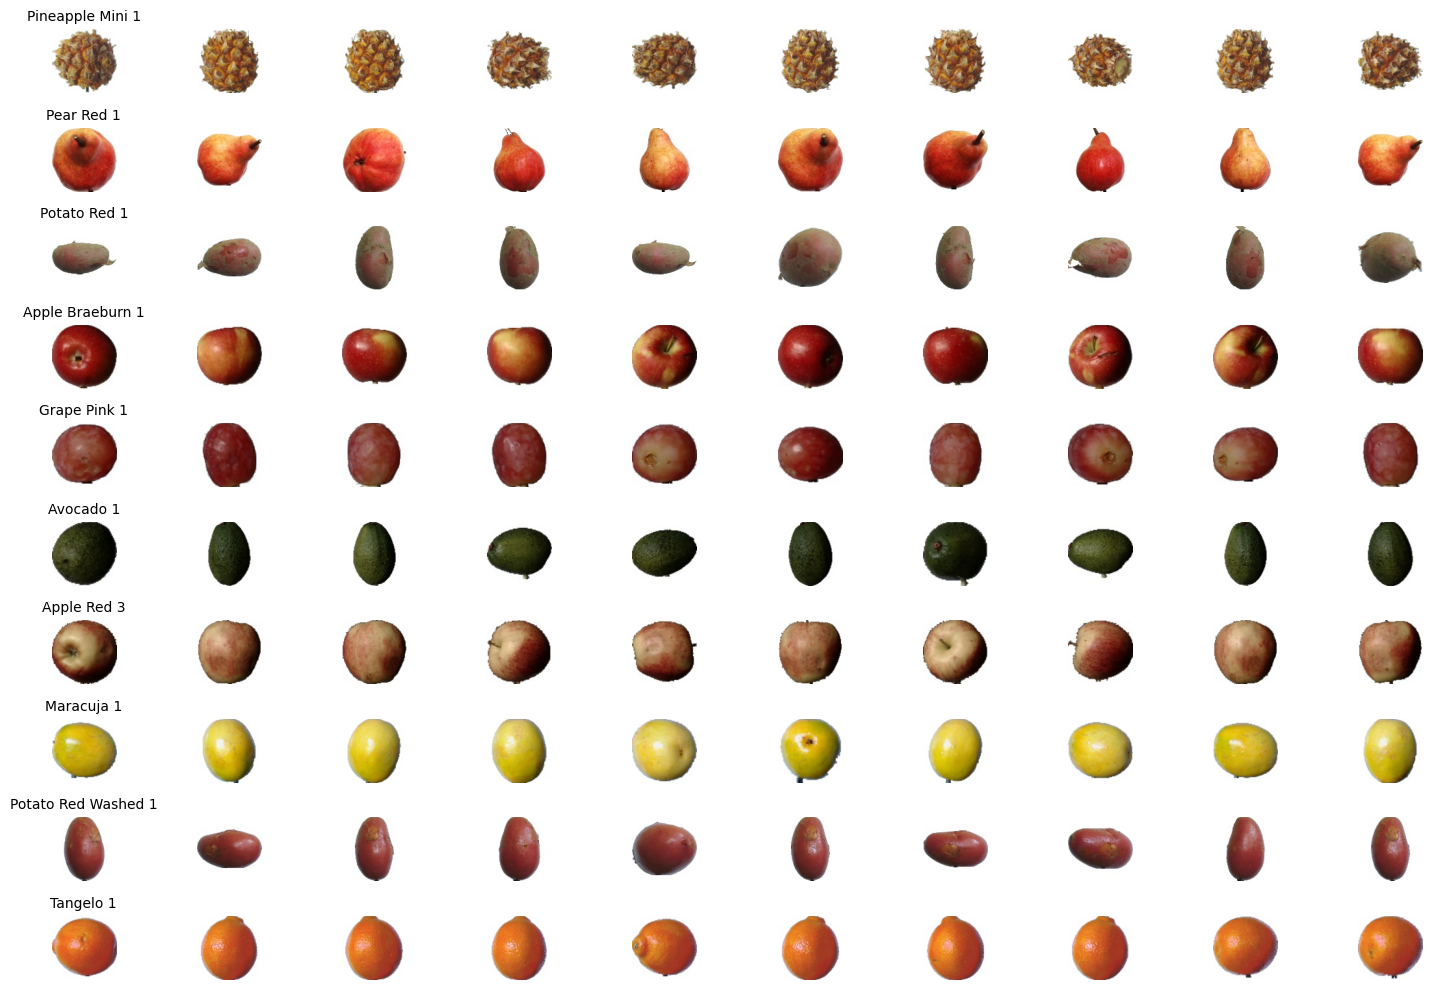

In [10]:
# visualiza imágenes de ejemplo
def mostrar_ejemplos(data_dir, classes, num_imagenes=5):
    fig, axes = plt.subplots(len(classes), num_imagenes, figsize=(15, 10))
    for i, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        images = os.listdir(folder)[:num_imagenes]
        for j, img_file in enumerate(images):
            img_path = os.path.join(folder, img_file)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls, fontsize=10)
    plt.tight_layout()
    plt.show()

mostrar_ejemplos(train_folder, classes[:10], num_imagenes=10)

---
### 1.3) Dataset reducido

Se utiliza un dataset reducido para acelerar el entrenamiento en la búsqueda de hiperparámetros.

In [46]:
def create_subset_folder(original_dir, subset_dir, classes_subset, images_per_class):
    if os.path.exists(subset_dir):
        shutil.rmtree(subset_dir)

    os.makedirs(subset_dir, exist_ok=True)

    for class_name in classes_subset:
        class_subset_dir = os.path.join(subset_dir, class_name)
        os.makedirs(class_subset_dir, exist_ok=True)

        image_files = [f for f in os.listdir(os.path.join(original_dir, class_name)) if os.path.isfile(os.path.join(original_dir, class_name, f))]
        selected_images = random.sample(image_files, min(images_per_class, len(image_files)))

        for image_file in selected_images:
            source_path = os.path.join(original_dir, class_name, image_file)
            destination_path = os.path.join(class_subset_dir, image_file)
            shutil.copy(source_path, destination_path)

num_classes_subset = 40
images_per_class = 50

random.seed(42)
class_folders = [f for f in os.listdir('Training') if os.path.isdir(os.path.join('Training', f))]
classes_subset = random.sample(class_folders, num_classes_subset)
print("Clases elegidas para el dataset reducido:")
print(classes_subset)

# Directorios para el subset
train_subset_folder = 'Training_subset'
test_subset_folder = 'Test_subset'
create_subset_folder(train_folder, train_subset_folder, classes_subset, int(images_per_class*0.8))
create_subset_folder(test_folder, test_subset_folder, classes_subset, int(images_per_class*0.2))

train_subset_images = sum([len(files) for r, d, files in os.walk(train_subset_folder)])
test_subset_images = sum([len(files) for r, d, files in os.walk(test_subset_folder)])
total_subset_images = train_subset_images + test_subset_images

print("")
print(f"Cantidad de imagenes en train subset: {train_subset_images}")
print(f"Cantidad de imagenes en test subset: {test_subset_images}")
print(f"Total de imagenes subset: {total_subset_images}")

Clases elegidas para el dataset reducido:
['Apple Pink Lady 1', 'Apple Red 3', 'Apple Red Yellow 2', 'Pineapple 1', 'Carrot 1', 'Strawberry Wedge 1', 'Onion Red Peeled 1', 'Lemon 1', 'Pomegranate 1', 'Potato Red Washed 1', 'Maracuja 1', 'Cauliflower 1', 'Tomato 1', 'Orange 1', 'Cherry Wax Red 1', 'Pomelo Sweetie 1', 'Apple Braeburn 1', 'Salak 1', 'Apple Golden 3', 'Cherry Rainier 1', 'Cherry 2', 'Hazelnut 1', 'Zucchini 1', 'Pitahaya Red 1', 'Potato Sweet 1', 'Banana Red 1', 'Pepino 1', 'Pear 1', 'Nut Forest 1', 'Apple Golden 1', 'Pineapple Mini 1', 'Plum 3', 'Peach Flat 1', 'Pepper Yellow 1', 'Banana Lady Finger 1', 'Ginger Root 1', 'Lychee 1', 'Watermelon 1', 'Physalis 1', 'Nut Pecan 1']

Cantidad de imagenes en train subset: 1600
Cantidad de imagenes en test subset: 400
Total de imagenes subset: 2000


---
### 1.2) Data Augmentation



In [12]:
# wip

---
## 2) Modelos

#### Funciones auxiliares

In [53]:
# Función de entrenamiento y validación
def train_and_evaluate(model, optimizer, criterion, data, epochs, device):
    train_loader, valid_loader = data["train"], data["valid"]

    results = {key: {"train": [], "valid": []} for key in metrics.keys()}

    start_time = time.time()
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        for train_data, train_target in train_loader:
            train_data, train_target = train_data.to(device), train_target.to(device)
            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            loss.backward()
            optimizer.step()

        # Evaluar en ambos conjuntos
        for phase, loader in [("train", train_loader), ("valid", valid_loader)]:
            model.eval()
            with torch.no_grad():
                epoch_metrics = {key: 0.0 for key in metrics.keys()}
                for data, target in loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    for key, metric in metrics.items():
                        epoch_metrics[key] += metric(output, target).item()

                # Guardar métricas promedio
                for key in metrics.keys():
                    results[key][phase].append(epoch_metrics[key] / len(loader))

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Accuracy: {results['accuracy']['train'][-1]:.4f}, Precision: {results['precision']['train'][-1]:.4f}, Recall: {results['recall']['train'][-1]:.4f}, F1: {results['f1']['train'][-1]:.4f}")
        print(f"  Valid - Accuracy: {results['accuracy']['valid'][-1]:.4f}, Precision: {results['precision']['valid'][-1]:.4f}, Recall: {results['recall']['valid'][-1]:.4f}, F1: {results['f1']['valid'][-1]:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Tiempo de entrenamiento: {training_time:.2f} s")

    # Guardar métricas en archivos
    model_name = model.__class__.__name__
    for key in metrics.keys():
        save_metric(f"{model_name}_{key}_train.txt", results[key]["train"])
        save_metric(f"{model_name}_{key}_valid.txt", results[key]["valid"])

    return results


# Funcion para guardar métricas en archivos
def save_metric(filename, values):
    with open(filename, "w") as file:
        for value in values:
            file.write(f"{value}\n")


# Funcion para graficar las metricas
def plot_metrics(title, results):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    for i, key in enumerate(metrics_to_plot):
        row = i // 2
        col = i % 2
        axes[row, col].plot(results[key]["train"], label=f"Train {key.capitalize()}", marker='o')
        axes[row, col].plot(results[key]["valid"], label=f"Valid {key.capitalize()}", marker='o')
        axes[row, col].set_xlabel("Epoch")
        axes[row, col].set_ylabel(key.capitalize())
        axes[row, col].set_title(f"{title} - {key.capitalize()}")
        axes[row, col].grid(alpha=0.5)
        axes[row, col].legend(loc='lower right')

    plt.tight_layout()
    plt.show()


# Función para visualizar predicciones correctas e incorrectas
def visualize_predictions_grid(model, data_loader, device, classes, num_images=5):
    model.eval()
    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for i in range(data.size(0)):
                if pred[i].item() == target[i].item():
                    if len(correct_predictions) < num_images:
                        correct_predictions.append((data[i], target[i], pred[i], i))
                else:
                    if len(incorrect_predictions) < num_images:
                        incorrect_predictions.append((data[i], target[i], pred[i], i))

                if len(correct_predictions) == num_images and len(incorrect_predictions) == num_images:
                    break
            else:
                continue
            break

    # Crear la cuadrícula de imágenes
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    # Mostrar las predicciones correctas
    for i, (image, target, pred, index) in enumerate(correct_predictions):
        print(f"Iteración {i}: target={target.item()}, pred={pred.item()}")
        ax = axes[0, i]
        ax.imshow(np.transpose(data[index].cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target.item()] if classes else target.item()
        nombre_clase_predicha = classes[pred.item()] if classes else pred.item()
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    # Mostrar las predicciones incorrectas
    for i, (image, target, pred, index) in enumerate(incorrect_predictions):
        ax = axes[1, i]
        ax.imshow(np.transpose(data[index].cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target.item()] if classes else target.item()
        nombre_clase_predicha = classes[pred.item()] if classes else pred.item()
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    plt.tight_layout()
    plt.show()


# Funcion para imprimir el tamaño del modelo
def print_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    model_size = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"Cantidad de parámetros: {total_params}")
    print(f"Tamaño del modelo: {model_size / (1024 * 1024):.2f} MB")


---
### 2.1) Modelo 1: VGG19

#### 2.1.1) Con el dataset reducido

In [34]:
# Configuración inicial
CANTIDAD_CLASES = 40
ANCHO_IMAGENES = 224 # requerido para VGG19
ALTO_IMAGENES = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Configuración de transformaciones con data augmentation
aug_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# carga de datasets
train_subset = torchvision.datasets.ImageFolder(root=train_subset_folder, transform=aug_data_transforms)
valid_subset = torchvision.datasets.ImageFolder(root=test_subset_folder, transform=data_transforms)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
vgg19_model = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in vgg19_model.parameters():
    param.requires_grad = False
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)
print_model_size(vgg19_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 139734120
Tamaño del modelo: 533.04 MB


In [27]:
vgg19_reduced_results = train_and_evaluate(vgg19_model, optimizer, criterion, data, EPOCHS, device)

Epoch 1/10
  Train - Accuracy: 0.4875, Precision: 0.3803, Recall: 0.3965, F1: 0.3726
  Valid - Accuracy: 0.4784, Precision: 0.3699, Recall: 0.4150, F1: 0.3759
Epoch 2/10
  Train - Accuracy: 0.6819, Precision: 0.5794, Recall: 0.5999, F1: 0.5721
  Valid - Accuracy: 0.6058, Precision: 0.4811, Recall: 0.5269, F1: 0.4854
Epoch 3/10
  Train - Accuracy: 0.7425, Precision: 0.6497, Recall: 0.6619, F1: 0.6415
  Valid - Accuracy: 0.6803, Precision: 0.5772, Recall: 0.5981, F1: 0.5700
Epoch 4/10
  Train - Accuracy: 0.7656, Precision: 0.6775, Recall: 0.6898, F1: 0.6705
  Valid - Accuracy: 0.7019, Precision: 0.5959, Recall: 0.6363, F1: 0.6001
Epoch 5/10
  Train - Accuracy: 0.7788, Precision: 0.6919, Recall: 0.7023, F1: 0.6836
  Valid - Accuracy: 0.7188, Precision: 0.5954, Recall: 0.6281, F1: 0.6010
Epoch 6/10
  Train - Accuracy: 0.7919, Precision: 0.7030, Recall: 0.7084, F1: 0.6927
  Valid - Accuracy: 0.7308, Precision: 0.6233, Recall: 0.6464, F1: 0.6207
Epoch 7/10
  Train - Accuracy: 0.8131, Precisi

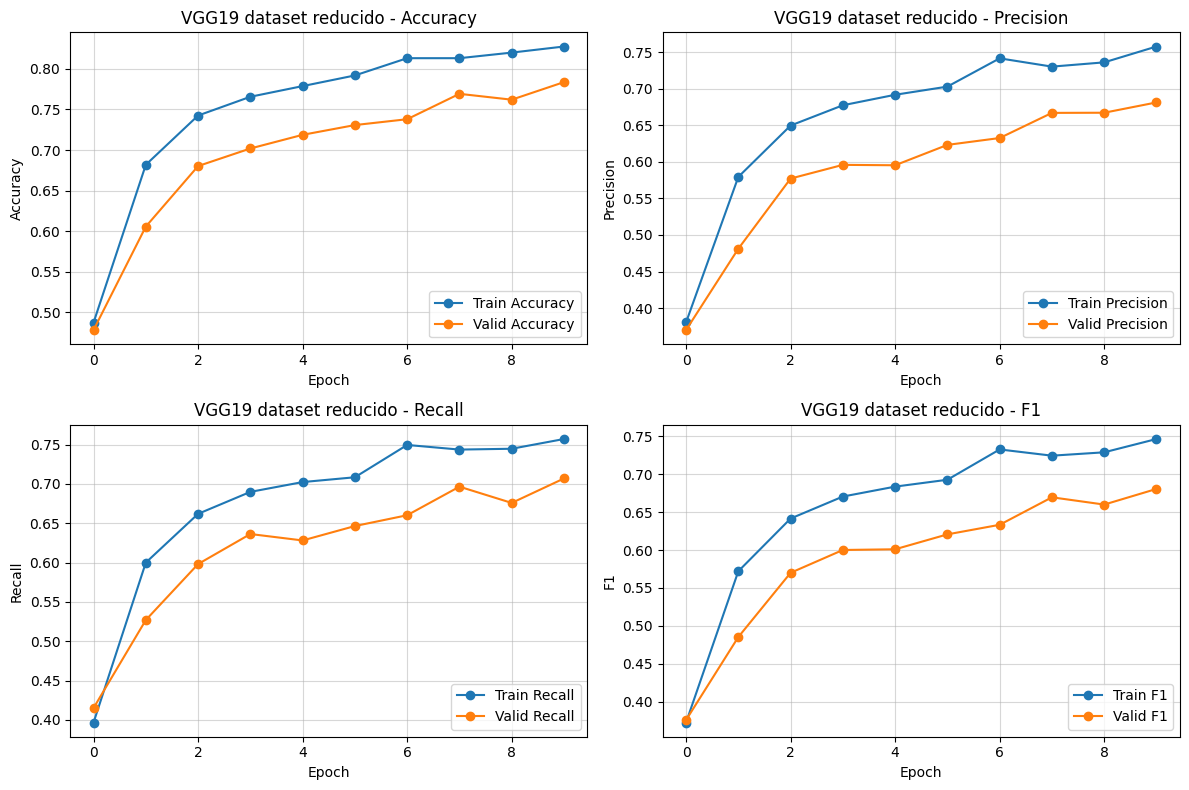

In [28]:
plot_metrics("VGG19 dataset reducido", vgg19_reduced_results)

In [ ]:
# TODO wip
# visualize_predictions_grid(vgg19_model, valid_loader, device, classes)

---
#### 2.1.2) Búsqueda de HP

In [ ]:
# TODO

---
#### 2.1.3) Con el dataset completo (training pending)

In [35]:
# Configuración inicial
CANTIDAD_CLASES = 141
ANCHO_IMAGENES = 224 # requerido para VGG19
ALTO_IMAGENES = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Configuración de transformaciones con data augmentation
aug_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# carga de datasets
train_set = torchvision.datasets.ImageFolder(root=train_folder, transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root=test_folder, transform=data_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
vgg19_model = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in vgg19_model.parameters():
    param.requires_grad = False
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)
print_model_size(vgg19_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 140147917
Tamaño del modelo: 534.62 MB


In [ ]:
# TODO Entrenar y evaluar el modelo
# vgg19_results = train_and_evaluate(vgg19_model, optimizer, criterion, data, EPOCHS, device)

In [ ]:
# plot_metrics("VGG19 dataset completo", vgg19_results)

---
### 2.2) Modelo 2: MobileNetV2

#### 2.2.1) Con el dataset reducido

In [40]:
# Configuración inicial
CANTIDAD_CLASES = 40
ANCHO_IMAGENES = 224 # requerido para MobileNetV2
ALTO_IMAGENES = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Configuración de transformaciones con data augmentation
aug_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# carga de datasets
train_subset = torchvision.datasets.ImageFolder(root=train_subset_folder, transform=aug_data_transforms)
valid_subset = torchvision.datasets.ImageFolder(root=test_subset_folder, transform=data_transforms)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
mobilenet_model = mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
for param in mobilenet_model.parameters():
    param.requires_grad = False
last_layer_in_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model.to(device)
print_model_size(mobilenet_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 2275112
Tamaño del modelo: 8.68 MB


In [41]:
mobilenet_reduced_results = train_and_evaluate(mobilenet_model, optimizer, criterion, data, EPOCHS, device)

Epoch 1/10
  Train - Accuracy: 0.2731, Precision: 0.1836, Recall: 0.2090, F1: 0.1817
  Valid - Accuracy: 0.2212, Precision: 0.1352, Recall: 0.1646, F1: 0.1366
Epoch 2/10
  Train - Accuracy: 0.5794, Precision: 0.4696, Recall: 0.4832, F1: 0.4576
  Valid - Accuracy: 0.5697, Precision: 0.4508, Recall: 0.4783, F1: 0.4442
Epoch 3/10
  Train - Accuracy: 0.7619, Precision: 0.6586, Recall: 0.6735, F1: 0.6513
  Valid - Accuracy: 0.7404, Precision: 0.6363, Recall: 0.6367, F1: 0.6255
Epoch 4/10
  Train - Accuracy: 0.8381, Precision: 0.7648, Recall: 0.7780, F1: 0.7598
  Valid - Accuracy: 0.8293, Precision: 0.7477, Recall: 0.7622, F1: 0.7437
Epoch 5/10
  Train - Accuracy: 0.8831, Precision: 0.8182, Recall: 0.8253, F1: 0.8131
  Valid - Accuracy: 0.8822, Precision: 0.8208, Recall: 0.8363, F1: 0.8196
Epoch 6/10
  Train - Accuracy: 0.8950, Precision: 0.8380, Recall: 0.8459, F1: 0.8336
  Valid - Accuracy: 0.8822, Precision: 0.8144, Recall: 0.8204, F1: 0.8121
Epoch 7/10
  Train - Accuracy: 0.9156, Precisi

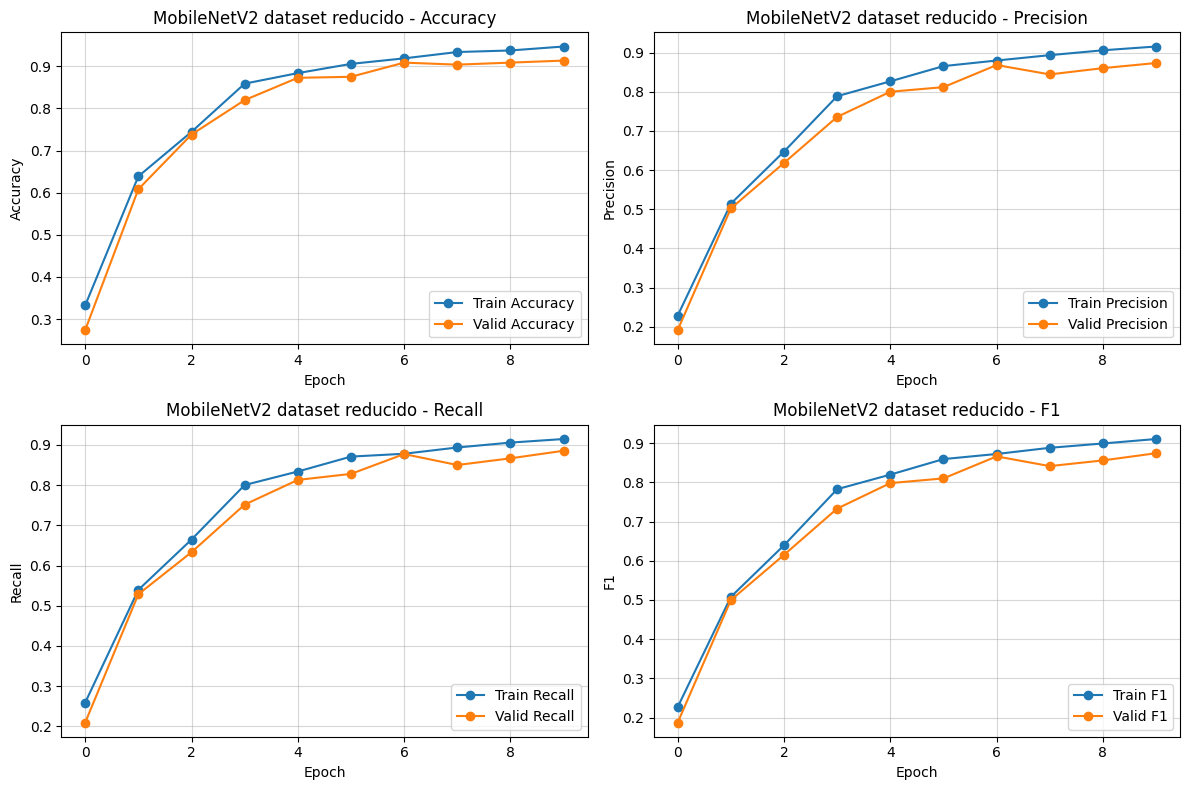

In [24]:
plot_metrics("MobileNetV2 dataset reducido", mobilenet_reduced_results)

In [ ]:
# TODO wip
# visualize_predictions_grid(mobilenet_model, valid_loader, device, classes_subset)

---
#### 2.2.2) Búsqueda de HP

In [ ]:
# TODO

---
#### 2.2.3) Con el dataset completo (training pending)

In [37]:
# Configuración inicial
CANTIDAD_CLASES = 141
ANCHO_IMAGENES = 224 # requerido para MobileNetV2
ALTO_IMAGENES = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Configuración de transformaciones con data augmentation
aug_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# carga de datasets
train_set = torchvision.datasets.ImageFolder(root=train_folder, transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root=test_folder, transform=data_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
mobilenet_model = mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
for param in mobilenet_model.parameters():
    param.requires_grad = False
last_layer_in_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model.to(device)
print_model_size(mobilenet_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 2404493
Tamaño del modelo: 9.17 MB


In [ ]:
# TODO: train full set
# mobilenet_results = train_and_evaluate(mobilenet_model, optimizer, criterion, data, EPOCHS, device)

---
#### 2.2.4) Resultados sin data augmentation

In [ ]:
# TODO

---
#### 2.2.5) Resultados sin Transfer Learning


In [58]:
# TODO

---

In [ ]:
# wip

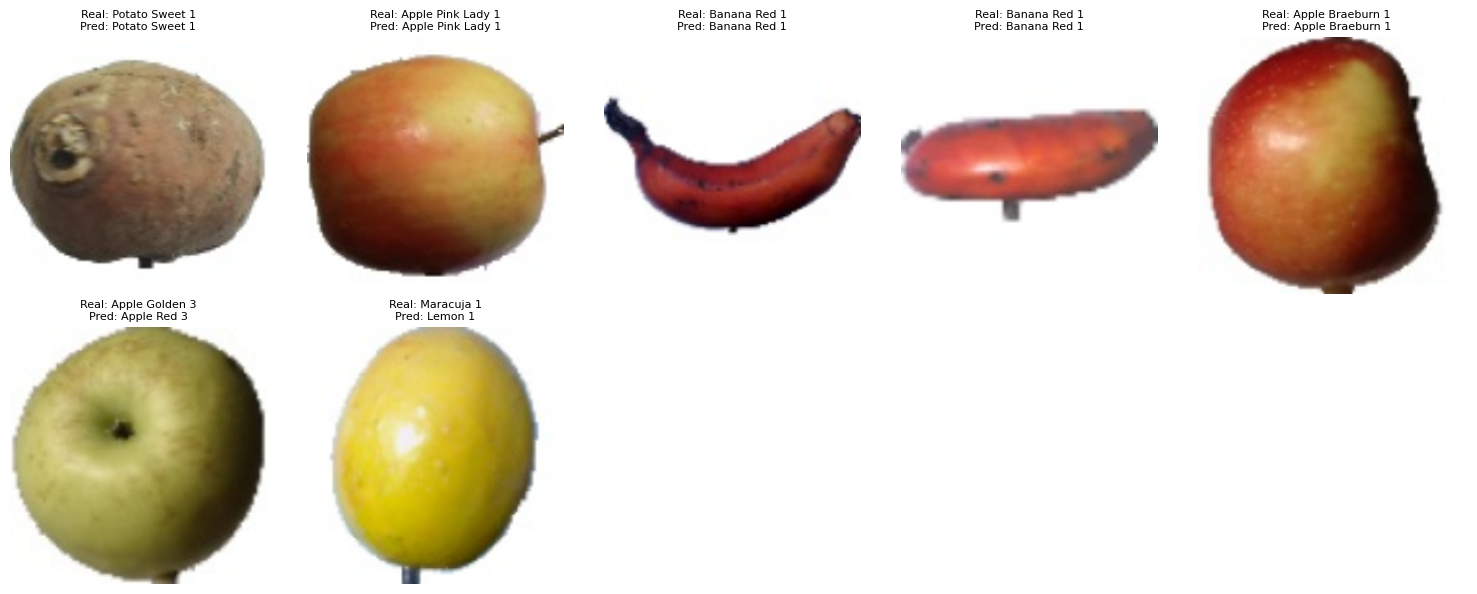

In [66]:
def visualize_predictions_grid(images, targets, predictions, classes=None, num_images=5):
    correct_indices = [i for i, (t, p) in enumerate(zip(targets, predictions)) if t == p]
    incorrect_indices = [i for i, (t, p) in enumerate(zip(targets, predictions)) if t != p]

    correct_images = [images[i] for i in correct_indices[:num_images]]
    correct_targets = [targets[i] for i in correct_indices[:num_images]]
    correct_predictions_list = [predictions[i] for i in correct_indices[:num_images]]

    incorrect_images = [images[i] for i in incorrect_indices[:num_images]]
    incorrect_targets = [targets[i] for i in incorrect_indices[:num_images]]
    incorrect_predictions_list = [predictions[i] for i in incorrect_indices[:num_images]]

    num_correct = len(correct_images)
    num_incorrect = len(incorrect_images)
    num_rows = 2
    num_cols = max(num_correct, num_incorrect)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    # Mostrar las predicciones correctas
    for i, (image, target, pred) in enumerate(zip(correct_images, correct_targets, correct_predictions_list)):
        ax = axes[0, i]
        ax.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target] if classes else target
        nombre_clase_predicha = classes[pred] if classes else pred
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    # Mostrar las predicciones incorrectas
    for i, (image, target, pred) in enumerate(zip(incorrect_images, incorrect_targets, incorrect_predictions_list)):
        ax = axes[1, i]
        ax.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target] if classes else target
        nombre_clase_predicha = classes[pred] if classes else pred
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    # Ocultar los subplots vacíos
    for i in range(num_correct, num_cols):
        axes[0, i].axis('off')  # Ocultar subplots vacíos en la fila superior
    for i in range(num_incorrect, num_cols):
        axes[1, i].axis('off')  # Ocultar subplots vacíos en la fila inferior

    plt.tight_layout()
    plt.show()

# Obtener un batch de datos del DataLoader
data, target = next(iter(valid_loader))
data, target = data.to(device), target.to(device)

# Obtener las predicciones del modelo
output = mobilenet_model(data)
pred = output.argmax(dim=1)

# Convertir las etiquetas y predicciones a listas de Python
target_list = target.cpu().tolist()
pred_list = pred.cpu().tolist()

# Visualizar las predicciones
visualize_predictions_grid(data, target_list, pred_list, classes=train_subset.classes)